# ECE-5424 / CS-5824 Advanced Machine Learning
# Assignment 1

In this assignment, **you need to complete the following four sectoins**:
1. KNN
2. Linear regression
3. Logistic regression
4. Regularization



## Submission guideline

1. Click the Save button at the top of the Jupyter Notebook.
2. Please make sure to have entered your Virginia Tech PID below.
3. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of ll cells).
4. Select Cell -> Run All. This will run all the cells in order.
5. Once you've rerun everything, select File -> Download as -> PDF via LaTeX
6. Look at the PDF file and make sure all your solutions are there, displayed correctly. 
7. Upload the PDF file and this notebook **INDEPENDENTLY**.
8. Please **DO NOT** uplaod any data.

### Please Write Your VT PID Here: 

# Section 1. KNN [25 pts]

The following KNN assignment is modified from [Stanford CS231n](http://cs231n.stanford.edu/). Please complete and hand in this completed worksheet.

In [1]:
# Run some setup code for this notebook.

from __future__ import print_function
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt


# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Download data:
Once you have the starter code (regardless of which method you choose above), you will need to download the CIFAR-10 dataset. Run the following from the assignment1 directory:

```cd data
./get_datasets.sh
```

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'data/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


0
1
2
3
4
5
6
7
8
9


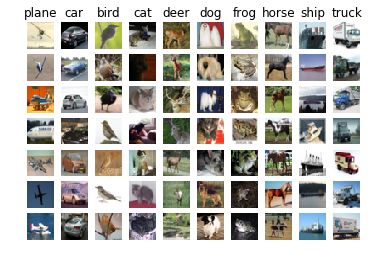

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [6]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


To make things much structural, we now put everything together into the KNearestNeighbor class. You don't need to implement any fucntion in this class now. Later you will need to come back here and implement the asked function, per the instruction.

In [51]:
class KNearestNeighbor(object):
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just 
    memorizing the training data.

    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X
    self.y_train = y
    
  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the 
    test data.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      for j in range(num_train):
        #####################################################################
        # TODO:                                                             #
        # Compute the l2 distance between the ith test point and the jth    #
        # training point, and store the result in dists[i, j]. You should   #
        # not use a loop over dimension.                                    #
        #####################################################################
        dists[i,j] = np.sqrt( np.sum( np.square(X[i,:] - self.X_train[j,:])))
        

        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################
    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      #######################################################################
      # TODO:                                                               #
      # Compute the l2 distance between the ith test point and all training #
      # points, and store the result in dists[i, :].                        #
      #######################################################################
        temp1 = self.X_train - X[i]
        temp2 = np.square(temp1)
        temp3 = np.sum(temp2, axis=1)
        dists[i] = np.sqrt(temp3)
      #######################################################################
      #                         END OF YOUR CODE                            #
      #######################################################################
    return dists

  def compute_distances_no_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
    #########################################################################
    # TODO:                                                                 #
    # Compute the l2 distance between all test points and all training      #
    # points without using any explicit loops, and store the result in      #
    # dists.                                                                #
    #                                                                       #
    # You should implement this function using only basic array operations; #
    # in particular you should not use functions from scipy.                #
    #                                                                       #
    # HINT: Try to formulate the l2 distance using matrix multiplication    #
    #       and two broadcast sums.                                         #
    #########################################################################
    ab = X.dot( np.transpose(self.X_train)) 
    a_square = np.matmul( np.sum( np.square(X), axis=1).reshape((-1,1)), np.ones((1, num_train)))
    b_square = np.transpose( np.matmul( np.sum( np.square(self.X_train), axis=1).reshape((-1,1)), np.ones((1, num_test))))
    dists = np.sqrt(a_square + b_square - 2*ab)

    #########################################################################
    #                         END OF YOUR CODE                              #
    #########################################################################
    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.

    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    closest_y = []
    for i in range(num_test):
      # A list of length k storing the labels of the k nearest neighbors to
      # the ith test point.

      #########################################################################
      # TODO:                                                                 #
      # Use the distance matrix to find the k nearest neighbors of the ith    #
      # testing point, and use self.y_train to find the labels of these       #
      # neighbors. Store these labels in closest_y.                           #
      # Hint: Look up the function numpy.argsort.                             #
      #########################################################################
        dists_sort = np.argsort(dists[i])
        k_locations = dists_sort[:k]
        k_labels = self.y_train[k_locations]
        
        
      #########################################################################
      # TODO:                                                                 #
      # Now that you have found the labels of the k nearest neighbors, you    #
      # need to find the most common label in the list closest_y of labels.   #
      # Store this label in y_pred[i]. Break ties by choosing the smaller     #
      # label.                                                                #
      #########################################################################
        y_pred[i] = np.argmax( np.bincount(k_labels))
        
        
      #########################################################################
      #                           END OF YOUR CODE                            # 
      #########################################################################

    return y_pred



In [52]:
# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [22]:
# Implement compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


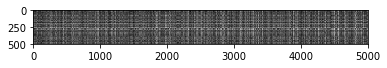

In [23]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**: *fill this in.*

Second, open k_nearest_neighbor.py and implement the function predict_labels that predicts a label for each test point.

In [34]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).train
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [35]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


**Inline Question 2**
We can also try other distance metrics such as L1 distance.
The performance of a Nearest Neighbor classifier that uses L1 distance will not change if (Select all that apply.):
1. The data is preprocessed by subtracting the mean.
2. The data is preprocessed by subtracting the mean and dividing by the standard deviation.
3. The coordinate axes for the data are rotated.
4. None of the above.

*Your Answer*:

*Your explanation*:

In [38]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [53]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [54]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 31.189436 seconds
One loop version took 34.107362 seconds
No loop version took 0.186613 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [57]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)
num_test = X_train.shape[0]/num_folds

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as traitrainning data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
for i,k in enumerate(k_choices):
    k_to_accuracies[k] = []
    for j in range(num_folds):
        dists = classifier.compute_distances_no_loops(X_train_folds[j])
        y_test_pred = classifier.predict_labels(dists, k)

        # Compute and print the fraction of correctly predicted examples
        num_correct = np.sum(y_test_pred == y_train_folds[j])
        accuracy = float(num_correct) / num_test
        print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
        k_to_accuracies[k].append(accuracy)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))


Got 1000 / 1000 correct => accuracy: 1.000000
Got 1000 / 1000 correct => accuracy: 1.000000
Got 1000 / 1000 correct => accuracy: 1.000000
Got 1000 / 1000 correct => accuracy: 1.000000
Got 1000 / 1000 correct => accuracy: 1.000000
Got 504 / 1000 correct => accuracy: 0.504000
Got 514 / 1000 correct => accuracy: 0.514000
Got 525 / 1000 correct => accuracy: 0.525000
Got 523 / 1000 correct => accuracy: 0.523000
Got 550 / 1000 correct => accuracy: 0.550000
Got 428 / 1000 correct => accuracy: 0.428000
Got 445 / 1000 correct => accuracy: 0.445000
Got 453 / 1000 correct => accuracy: 0.453000
Got 453 / 1000 correct => accuracy: 0.453000
Got 488 / 1000 correct => accuracy: 0.488000
Got 375 / 1000 correct => accuracy: 0.375000
Got 407 / 1000 correct => accuracy: 0.407000
Got 397 / 1000 correct => accuracy: 0.397000
Got 402 / 1000 correct => accuracy: 0.402000
Got 404 / 1000 correct => accuracy: 0.404000
Got 366 / 1000 correct => accuracy: 0.366000
Got 396 / 1000 correct => accuracy: 0.396000
Got 3

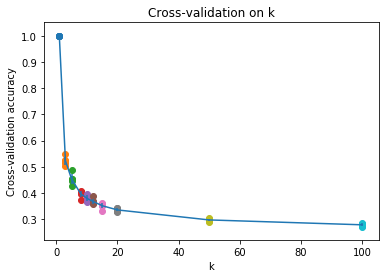

In [58]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [59]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 1000 correct => accuracy: 0.137000


**Inline Question 3**
Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The training error of a 1-NN will always be better than that of 5-NN.
2. The test error of a 1-NN will always be better than that of a 5-NN.
3. The decision boundary of the k-NN classifier is linear.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

*Your Answer*:

*Your explanation*:

# Section 2. Linear Regression [25 pts]

The following linear regression assignment is modified from [Stanford CS229](http://cs229.stanford.edu//). Please complete and hand in this completed worksheet.

## Linear regression with one variable

Before starting on any task, it is often useful to understand the data by visualizing it. For this dataset, you can use a scatter plot to visualize the data, since it has only two properties to plot (profit and population). (Many other problems that you will encounter in real life are multi-dimensional and can’t be plotted on a 2-d plot.)

The dataset is loaded from the data file into the variables X and y:

In [60]:
data = np.loadtxt('data/ex1data1.txt', delimiter=",") # read comma separated data
m = data.shape[0]                                     # number of training example
X = data[:,0].reshape(m,1)
y = data[:,1].reshape(m,1)                             

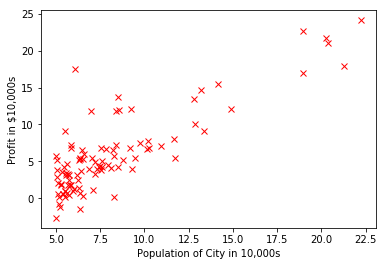

In [61]:
plt.plot(X,y, 'rx')                         # Plot the data
plt.xlabel('Population of City in 10,000s')
plt.ylabel('Profit in $10,000s')
plt.show()

In this part, you will fit the linear regression parameters $\theta$ to our dataset
using gradient descent.

The objective of linear regression is to minimize the cost function
\begin{equation*}
J(\theta) = \frac{1}{2m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})^2
\end{equation*}


where the hypothesis $h_\theta(x)$ is given by the linear mode
\begin{equation*}
h_{\theta}(x^{(i)}) = \theta^Tx = \theta_0 + \theta_1 x_1
\end{equation*}


Recall that the parameters of your model are the $\theta_j$ values. These are
the values you will adjust to minimize cost $J(\theta)$. One way to do this is to
use the batch gradient descent algorithm. In batch gradient descent, each
iteration performs the update
\begin{equation*}
\theta_j := \theta_j - \alpha \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)}) x_j^{(i)}
\end{equation*}

With each step of gradient descent, your parameters $\theta_j$ come closer to the
optimal values that will achieve the lowest cost $J(\theta)$.

As you perform gradient descent to learn minimize the cost function J(θ), it is helpful to monitor the convergence by computing the cost. In this section, you will implement a function to calculate J(θ) so you can check the convergence of your gradient descent implementation.

Your next task is to complete the `compute_cost` function, which is a function that computes J(θ). As you are doing this, remember that the variables X and y are not scalar values, but matrices whose rows represent the examples from the training set.

In [62]:
def compute_cost(X, y, theta):
    m = len(y); # number of training examples

    # You need to return the following variables correctly 
    J = 0;
    #####################################################################
    # Compute the cost of a particular choice of theta                  #
    #               You should set J to the cost.                       #
    #####################################################################
    temp1 = np.square( X.dot(theta) - y)
    temp2 = np.sum(temp1)
    J = temp2 / 2 / m
    
    #####################################################################
    #                       END OF YOUR CODE                            #
    ####################################################################
    return J

In [63]:
X = np.concatenate((np.ones((m, 1)), data[:,0].reshape(m,1)), axis=1)
theta = np.zeros((2, 1)) 

compute_cost(X, y, theta)

32.072733877455676

You should expect to see a cost of 32.07.

Next, you will implement gradient descent function. The loop structure has been written for you, and you only need to supply the updates to θ within each iteration.

As you program, make sure you understand what you are trying to optimize and what is being updated. Keep in mind that the cost J(θ) is parameterized by the vector θ, not X and y. That is, we minimize the value of J(θ) by changing the values of the vector θ, not by changing X or y.

A good way to verify that gradient descent is working correctly is to look at the value of J(θ) and check that it is decreasing with each step. The starter code calls `compute_cost` on every iteration and prints the cost. Assuming you have implemented gradient descent and `compute_cost` correctly, your value of J(θ) should never increase, and should converge to a steady value by the end of the algorithm.

In [64]:
def gradient_descent(X, y, theta, alpha, num_iters):
    # GRADIENTDESCENT Performs gradient descent to learn theta
    # theta = GRADIENTDESCENT(X, y, theta, alpha, num_iters) updates theta by 
    # taking num_iters gradient steps with learning rate alpha

    # Initialize some useful values
    m = len(y)
    J_history = []

    
    for iter in range(num_iters):

        
        #####################################################################
        # Instructions: Perform a single gradient step on the parameter     #
        #               vector theta.                                       #
        #                                                                   #      
        # Hint: While debugging, it can be useful to print out the values   #
        #       of the cost function (compute_cost) and gradient here.       # 
        #####################################################################
        temp1 = np.transpose(X).dot(X.dot(theta) - y)
        theta = theta - alpha / m * temp1
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################
    

        # Save the cost J in every iteration 
        J = compute_cost(X, y, theta)
        J_history.append(J)
    
    return theta, J_history

Now let's find the parameter θ and plot the linear fit. 

Running Gradient Descent ...

Theta found by gradient descent: 
[-3.63029144] [1.16636235]


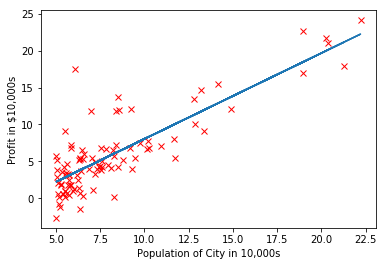

In [65]:
print('Running Gradient Descent ...\n')

X = np.concatenate((np.ones((m, 1)), data[:,0].reshape(m,1)), axis=1) # Add a column of ones to x
theta = np.zeros((2, 1))                                              # initialize fitting parameters

# Some gradient descent settings
iterations = 1500
alpha = 0.01

# gradient descent
theta, J_history = gradient_descent(X, y, theta, alpha, iterations)
print('Theta found by gradient descent: ')
print(theta[0], theta[1])


plt.plot(X[:,1], y, 'rx')                         # Plot the data
plt.xlabel('Population of City in 10,000s')
plt.ylabel('Profit in $10,000s')

plt.plot(X[:,1], np.dot(X, theta), '-')
plt.show()

## Linear regression with multiple variable

In this part, you will implement linear regression with multiple variables to predict the prices of houses. Suppose you are selling your house and you want to know what a good market price would be. One way to do this is to first collect information on recent houses sold and make a model of housing prices.

The file ex1data2.txt contains a training set of housing prices in Portland, Oregon. The first column is the size of the house (in square feet), the second column is the number of bedrooms, and the third column is the price
of the house.

In [72]:
data = np.loadtxt('data/ex1data2.txt', delimiter=",") # read comma separated data
m = data.shape[0]                                     # number of training example
X = data[:,0:2].reshape(m,2)
y = data[:,2].reshape(m,1)   

By looking at the values, note that house sizes are about 1000 times the number of bedrooms. When features differ by orders of magnitude, first performing feature scaling can make gradient descent converge much more quickly.

In [75]:
def feature_normalize(X):
    
    # FEATURENORMALIZE Normalizes the features in X 
    #   FEATURENORMALIZE(X) returns a normalized version of X where the mean value of each
    #   feature is 0 and the standard deviation is 1. This is often a good preprocessing 
    #   step to do when working with learning algorithms.

    # You need to set these values correctly
    X_norm = X
    mu     = 0
    sigma  = 0

    #####################################################################
    # Instructions: First, for each feature dimension, compute the mean #
    #               of the feature and subtract it from the dataset,    #
    #               storing the mean value in mu. Next, compute the     #
    #               standard deviation of each feature and divide       #
    #               each feature by it's standard deviation, storing    #
    #               the standard deviation in sigma.                    #
    #                                                                   #
    #               Note that X is a matrix where each column is a      #
    #               feature and each row is an example. You need        #
    #               to perform the normalization separately for         #
    #               each feature.                                       #
    #                                                                   #
    # Hint: You might find the 'mean' and 'std' functions useful.       #
    #####################################################################
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - mu) / sigma
    
    
    #####################################################################
    #                       END OF YOUR CODE                            #
    #####################################################################
        

    return X_norm, mu, sigma

Previously, you implemented gradient descent on a univariate regression problem. The only difference now is that there is one more feature in the matrix X. The hypothesis function and the batch gradient descent update
rule remain unchanged.

You should complete the function gradientDescentMulti to implement the gradient descent for linear regression with multiple variables.

Make sure your code supports any number of features and is well-vectorized.

In [76]:
X = np.concatenate((np.ones((m, 1)),feature_normalize(data[:,0:2].reshape(m,2))[0]), axis=1)
theta = np.zeros((3, 1)) 

compute_cost(X, y, theta)

65591548106.45744

You should expect to see a cost of 65591548106.

Next, you will implement gradient descent function with multiple variable.

In [77]:
def gradient_descent_multi(X, y, theta, alpha, num_iters):
    #GRADIENTDESCENTMULTI Performs gradient descent to learn theta
    #   theta = GRADIENTDESCENTMULTI(x, y, theta, alpha, num_iters) updates theta by
    #   taking num_iters gradient steps with learning rate alpha

    # Initialize some useful values
    m = len(y)
    J_history = []

    
    for iter in range(num_iters):

        
        #####################################################################
        # Instructions: Perform a single gradient step on the parameter     #
        #               vector theta.                                       #
        #                                                                   #      
        # Hint: While debugging, it can be useful to print out the values   #
        #       of the cost function (compute_cost) and gradient here.      # 
        #####################################################################
        temp1 = np.transpose(X).dot(X.dot(theta) - y)
        theta = theta - alpha / m * temp1
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################
    

        # Save the cost J in every iteration 
        J = compute_cost(X, y, theta)
        print(J)
        J_history.append(J)
    
    return theta, J_history

Now let's find the parameter θ and plot the linear fit.

In [78]:
alpha = 0.01;
num_iters = 400;

theta = np.zeros((3, 1))
theta, J_history = gradient_descent_multi(X, y, theta, alpha, num_iters)


64297776251.62011
63031018305.52132
61790694237.53249
60576236901.991035
59387091739.9886
58222716488.38939
57082580895.8954
55966166445.97885
54872966086.50778
53802483965.89506
52754235175.605446
51727745498.85994
50722551165.380974
49738198612.02588
48774244249.16025
47830254232.6268
46905804241.168976
46000479259.1725
45113873364.59137
44245589521.92844
43395239380.14428
42562443075.37121
41746829038.312386
40948033806.20948
40165701839.264984
39399485341.4087
38649044085.30024
37914045241.46274
37194163211.44539
36489079464.91514
35798482380.58049
35122067090.852936
34459535330.1538
33810595286.77683
33174961458.219242
32552354509.895863
31942501137.153576
31345133930.50523
30759991244.004223
30186817066.683086
29625360896.981297
29075377620.089474
28536627388.13903
28008875503.167995
27491892302.795826
26985453048.541317
26489337816.71971
26003331391.85654
25527223162.557613
25060807019.775593
24603881257.415604
24156248475.223606
23717715483.90246
23288093212.40244
22867196617.3

Let's plot the convergence graph

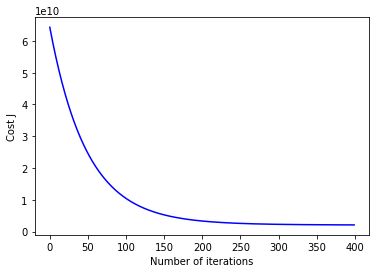

In [79]:
plt.plot(list(range(0, len(J_history))), J_history, '-b')                         # Plot the data
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')
plt.show()

# Section 3. Logistic Regression [25 pts]

The following logistic regression assignment is modified from [Stanford CS229](http://cs229.stanford.edu//). Please complete and hand in this completed worksheet.

## Logistic Regression
In this section, you need to implement logsitic regression to solve a binary classification problem. Let's first get our data ready:

In [215]:
# Only use the first 70 samples for training (and validation),
# and treat the rest of them as hold-out testing set.
X = np.loadtxt('data/logistic_x_.txt') 
y = np.loadtxt('data/logistic_y_.txt').reshape(-1, 1) 


X, mu, std = feature_normalize(X)

# Add a column of ones to X for the bias weight.
m = len(X)
X = np.concatenate((np.ones((m, 1)), X), axis=1)

Here, the input $x^{(i)}\in\mathbb{R^2}$ and $y^{(i)}\in\{-1, 1\}$. Like we have mentioned, it is better to visualize the data first before you start working on it.

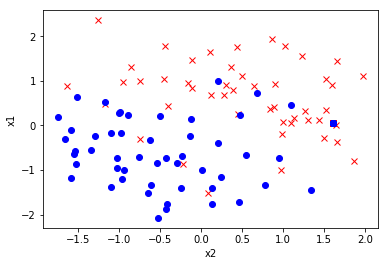

In [216]:
# Plot the feature according to their class label.
# Note that we exclude column 0, which is the colunm we padded with one in the previous block.
plt.plot(X[np.where(y==1), 1], X[np.where(y==1), 2], 'rx')
plt.plot(X[np.where(y==-1), 1], X[np.where(y==-1), 2], 'bo')  
plt.xlabel('x2')
plt.ylabel('x1')
plt.show()

In the following, you need to implement logistic regression. Recall that when $y^{(i)}\in{-1,1}$, the objective function for binary logistic regression can be expressed as:
\begin{equation*}
J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\log{\left(1+e^{-y^{(i)\theta^Tx^{(i)}}}\right)}=-\frac{1}{m}\sum_{i=1}^m\log{\left(h_{\theta}(y^{(i)}x^{(i)})\right)}
\end{equation*}
where the hypothesis is the **sigmoid function**: 
\begin{equation*}
h_\theta(y^{(i)}x^{(i)})=\frac{1}{1+e^{-y^{(i)}\theta^{T}x^{(i)}}}
\end{equation*}
which we have seen in class (and assignment 0). Similar to the previous section, we can minimize the objective function $J(\theta)$ using  batch gradient descent:
\begin{equation*}
\theta_j := \theta_j - \alpha \frac{1}{m}\sum_{i=1}^{m}h_\theta(-y^{(i)}x_j^{(i)})(-y^{(i)}x_j^{(i)})
\end{equation*}

Now, your task is to complete the function `sigmoid`, `compute_cost`, `gradient_descent` for logistic regression.

In [217]:
def sigmoid(z):
    #####################################################################
    # Instructions: Implement sigmoid function g                        #
    #####################################################################
    g = 1/ (1 + np.exp(-z))
    
    
    #####################################################################
    #                       END OF YOUR CODE                            #
    #####################################################################
    return g

def compute_cost(X, y, theta):
    
    # You need to return the following variables correctly 
    J = 0;
    eps = 1e-10
    #####################################################################
    # Instructions: Implement the objective function J(theta)           #
    #####################################################################
    temp1 = np.sum( np.log(eps + sigmoid(y*X.dot(theta))))
    J = temp1 / m * -1
        
    
    
    #####################################################################
    #                       END OF YOUR CODE                            #
    #####################################################################
    return J

def compute_gradient(X, y, theta):
    #####################################################################
    # Instructions: Implement gradient function gradient_               #
    #####################################################################
    temp1 = np.transpose(-y*X)
    gradient_ = temp1.dot( sigmoid(-y*X.dot(theta)))
    #####################################################################
    #                       END OF YOUR CODE                            #
    #####################################################################
    return gradient_


def gradient_descent_logistic(X, y, theta, alpha, num_iters):
    m = len(y)
    J_history = []
    for iter in range(num_iters):

        
        #####################################################################
        # Instructions: Perform a single gradient step on the parameter     #
        #               vector theta using the implemented compute_gradient #
        #                                                                   #      
        # Hint: While debugging, it can be useful to print out the values   #
        #       of the cost function (compute_cost) and gradient here.      # 
        #####################################################################
        gradient_ = compute_gradient(X, y, theta)
        theta = theta - alpha / m * gradient_
        
        
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################
    

        # Save the cost J in every iteration 
        J = compute_cost(X, y, theta)
        print(J)
        J_history.append(J)
    
    return theta, J_history

Now, fit your model, and see if it is learning.

In [218]:
# Train your model.
theta = np.zeros((X.shape[1], 1))
print(X.shape[1])
alpha = 0.1;
num_iters = 400;
theta, J_history = gradient_descent_logistic(X, y, theta, alpha, num_iters)

3
0.6767318707548591
0.6612759834239691
0.6467213866611489
0.6330122171674143
0.6200951052463477
0.6079193218588184
0.5964368588792431
0.5856024537720461
0.5753735692744317
0.5657103377142721
0.5565754784602017
0.5479341958097119
0.5397540634519212
0.5320049005484785
0.524658643490035
0.517689216521434
0.5110724036889106
0.504785723942013
0.4988083107118518
0.4931207968734482
0.4877052056703669
0.48254484792174224
0.4776242256333592
0.4729289419849723
0.46844561755623426
0.4641618125755091
0.460065954922759
0.4561472735841155
0.4523957372371186
0.4488019976382988
0.4453573374858444
0.4420536224372426
0.43888325697316916
0.435839143813146
0.43291464660449125
0.430103555623039
0.4274000562414048
0.4247986999377635
0.4222943776348726
0.4198822951751989
0.4175579507533479
0.4153171141414521
0.4131558075567343
0.4110702880330659
0.40905703117005404
0.40711271614398564
0.40523421187492076
0.403418564253364
0.40166298433832814
0.3999648374462762
0.398321633057436
0.3967310154723892
0.39519075

Again, plot and check to see if the model is converging.

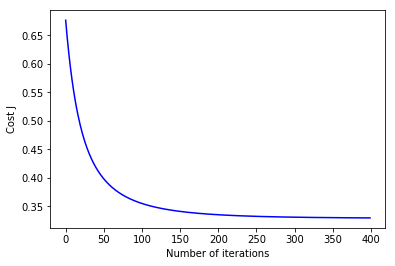

In [219]:
plt.plot(list(range(0, len(J_history))), J_history, '-b')  
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')
plt.show()

## Decision Boundary
In addition to checking convergence graph and accuracy, we can also plot out the decision boundary to see what does the model actually learn.

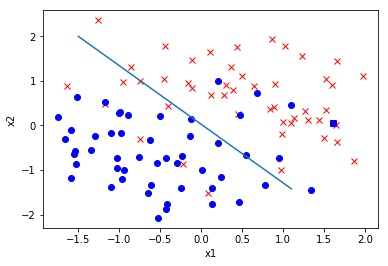

In [221]:
# Plot the feature according to their class label.
# Note that we exclude column 0, which is the colunm we padded with one in the previous block.
plt.plot(X[np.where(y==1), 1], X[np.where(y==1), 2], 'rx')
plt.plot(X[np.where(y==-1), 1], X[np.where(y==-1), 2], 'bo')

#####################################################################
# Instructions: Plot out the decision boundary.                     #
# Hint: To plot the boundary, which is a straight line in our case, #
#       you need to find the two ends of the line, and plot it with #
#       plt.plot(). Note that the decision boundary is the line that#
#       y = 0.                                                      # 
#####################################################################
x2_1 = (theta[0] + theta[1]*-1.5) / -theta[2]
x2_2 = (theta[0] + theta[1]*2.0) / -theta[2]

x_1 = [-1.5, x2_1]
x_2 = [2.0, x2_2]
plt.plot(x_1,x_2)
#####################################################################
#                       END OF YOUR CODE                            #
#####################################################################

plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Section 4. Regularization [25 pts]

In this section, you need to incorporate L2 regularization into your logistic regression. 

## L2 Regularization
Overfitting is a notorious problem in the world of machine learning. One simple way to counter this issue is to put constraints on your model weights $\theta$, as we have discussed in class. In this section, you need to modify the the objective function to impose L2 regularization on the logistic regression:
\begin{equation*}
    J(\theta) = -\frac{1}{m}\sum_{i=1}^m\log{\left(h_{\theta}(y^{(i)}x^{(i)})\right)} + \lambda\vert\vert\theta\vert\vert_2^2
\end{equation*}
Derive the gradient for this new objective to incorporate it into your logistic regression model.

To make things much structural, we now put everything together into a class. Please use the class template below to implement your logistic regression. Note that you can add your own class methods if needed.

In [262]:
class LogisticRegression(object):
    
    def __init__(self, alpha=0.1, lamb=0.1, regularization=None):
        # setting the class attribute.
        self.alpha = alpha                   # Set up your learning rate alpha.
        self.lamb = lamb                     # Strength of regularization.
        self.regularization = regularization 
        assert regularization == 'l2' or regularization == None # we only consider these two cases
    
    def _compute_cost(self, X, y):
        #####################################################################
        # Instructions: Compute the cost function here.                     #
        #               You need to handle both the cases with, and without #
        #               regularization here.                                #
        #####################################################################
        eps = 1e-10
        if (self.regularization == None):
            temp1 = np.sum( np.log(eps + sigmoid((y*X).dot(self.theta))))
            J = temp1 / len(y) * -1
        else:
            temp1 = np.sum( np.log(eps + sigmoid((y*X).dot(self.theta))))
            temp2 = self.lamb * np.sum( np.square(self.theta))
#             print("temp2", temp2)
            J = temp1 / len(y) * -1 + temp2/m/2
            
            
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################
        return J
        
    def _compute_gradient(self, X, y):
        #####################################################################
        # Instructions: Compute the gradient here.                          #
        #               You need to handle both the cases with, and without #
        #               regularization here.                                #
        #####################################################################
        if (self.regularization == None):
            temp1_ = np.transpose(-y*X)
            gradient = temp1_.dot( sigmoid((-y*X).dot(self.theta))) / len(y)
        else:
            temp1_ = np.transpose(-y*X)
            temp2_ = 2 * self.lamb * self.theta
#             print("gradient", temp2_)
            gradient = temp1_.dot( sigmoid((-y*X).dot(self.theta))) / len(y) + temp2_/len(y)/2
            
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################
        return gradient

    def fit(self, X, y, num_iter=5):
        self.theta = np.zeros((X.shape[1], 1))
        m = len(y)
        J_history = []
        #####################################################################
        # Instructions: Run the gradient decsent here.                      #
        #####################################################################
        for iter in range(num_iter):
            gradient1 = self._compute_gradient(X, y)
            self.theta = self.theta - self.alpha * gradient1

            J = self._compute_cost(X, y)
            print(J)
            J_history.append(J)
        
        
        
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################
        return J_history
    
    def predict(self, X):
        #####################################################################
        # Instructions: Use your hypothese to make predictions.             #
        #####################################################################
        y_hat = sigmoid(X.dot(self.theta))

        
        #####################################################################
        #                       END OF YOUR CODE                            #
        #####################################################################
        return y_hat

Load the wine datasets, in which $x_j\in\mathbb{R}^{12}$ is different attribute for alcohol, and $y\in\{-1,1\}$ is that class label (red or white wine).

In [263]:
# Load dataset
X_train = np.loadtxt('data/wine_train_X.txt')
y_train = np.loadtxt('data/wine_train_y.txt').reshape(-1, 1)
X_test = np.loadtxt('data/wine_test_X.txt')
y_test = np.loadtxt('data/wine_test_y.txt').reshape(-1, 1)

X_train = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1)
X_test = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)


Now, let's train two different logistic regression models: one with, and one without regularization.

In [264]:
log_reg = LogisticRegression(alpha=0.1) # Without regularization
log_reg_l2 = LogisticRegression(alpha=0.1, lamb=1.0, regularization='l2') # Without regularization

J_history = log_reg.fit(X_train, y_train, num_iter=500)
print("here")
J_history_l2 = log_reg_l2.fit(X_train, y_train, num_iter=500)
print(X_train.shape)

11.537935619990888
11.48252800627564
11.54170777858278
11.541666475954475
9.169961680846882
11.484143151257678
11.541707757037452
11.123680965320352
3.3880616019451013
11.484143151257678
11.53878551993601
10.327305427785882
3.3007037429460477
11.484143151257678
11.519934292208625
9.734141745903546
3.776640235744624
11.484143151257678
11.397267135479623
9.24100090447395
4.096416602569811
11.46482749838251
11.101038753364515
8.910411761642889
4.371535760914492
10.243558695949682
10.538965986154412
8.243974108967228
3.2669827996249485
8.155045388803153
9.376843199310764
6.6368146916299064
2.605362653571762
6.249454398129132
8.15320774052012
3.77697881067391
5.816763961378008
7.7675654555908
3.122032316023568
5.084372950282926
6.667024308569898
2.5946008279814454
7.224269223111716
8.344029910324116
4.751858776379429
3.3026006368117318
2.6134351556037068
6.785692871612429
8.08835574777773
4.387059448167903
3.4416771187259783
2.7986957891037
5.542970323446905
6.790212568238463
2.708601758213

4.244169504959883
4.202751832313142
4.238186082945139
4.19748746120287
4.230474134052839
4.191314841294923
4.220155663206271
4.183712145557943
4.20584015138258
4.17407845047687
4.186137659044702
4.163601918460432
4.165577953331953
4.160092725063611
4.169402381135407
4.162755711031125
4.193377138956274
4.171150512794573
4.23608167308685
4.1936456695411035
4.329480871637672
4.198869540894148
4.349844351765995
4.188426220313898
4.308307780675614
4.190231589761311
4.3172466993585505
4.18466836317406
4.29734509646234
4.1794856475514
4.28094106217347
4.171773654419682
4.257086768056409
4.159010234118096
4.2183931332197515
4.137547350121672
4.155521579965383
4.144711839570397
4.194840272418734
4.135728319687647
4.17573048865661
4.141571778744136
4.20905932918335
4.140864524801244
4.2170023723418195
4.143083449105092
4.234784388794021
4.1494835908243
4.266742488792141
4.165362439565715
4.332332687281741
4.188448511605282
4.421199019803594
4.170331730172098
4.341990139544425
4.173165689417526
4

Next, we evaluate the accuracy for each method:

In [253]:
def evaluate_accuracy(X, y, model):
    y_pred = model.predict(X)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = -1
    return np.mean(y_pred == y)

print("Accuracy on training set: ", evaluate_accuracy(X_train, y_train, log_reg))
print("Accuracy on testing set: ", evaluate_accuracy(X_test, y_test, log_reg))
print("Accuracy w/ L2 training set: ", evaluate_accuracy(X_train, y_train, log_reg_l2))
print("Accuracy w/ L2 testing set: ", evaluate_accuracy(X_test, y_test, log_reg_l2))

Accuracy on training set:  0.78125
Accuracy on testing set:  0.7925
Accuracy w/ L2 training set:  0.8225
Accuracy w/ L2 testing set:  0.865


To see the effect of regularization on $\theta$, we can plot out each $\theta_j$ under different $\lambda$.

In [254]:
def plot_theta(theta, lamb):
    """
    Helper function for plotting out the value of theta with respect to different lambda.
    theta  (list): list of theta under different lambda.
    lambda (list): list of lambda values you tried.
    """
    plt.hlines(y=0, xmin=0, xmax=np.max(lamb), color='red', linewidth = 2, linestyle = '--')
    for i in range(theta.shape[1]):
        plt.plot(lamb, theta[:,i])
    plt.ylabel('theta')
    plt.xlabel('lambda')
    plt.xscale('log')
    plt.show()

11.53228229339865
11.481720093356447
11.490827119616657
11.52166718689137
9.165312842324443
11.477339467519249
11.497327771874714
11.104098414500974
3.379223200694694
11.471020806951387
11.486411853630381
10.298397236211809
3.2803047116205954
11.46273347145905
11.455757886014526
9.693798855856919
3.746514373925415
11.452092119256006
11.319277617274178
9.187034756237853
4.053013420670029
11.41986730359683
11.00686638421327
8.840839544144284
4.312970117181556
10.174576607053245
10.431940914568433
8.1568890164063
3.183139462386488
8.04942719503558
9.249378099681557
6.498383033097369
2.538701293881903
4.9634491474522395
6.80710756633503
2.4891408973836247
7.900047236781133
8.78734620216469
5.7686326190303765
2.766284910996826
2.7729031733199374
2.7100582729014917
2.8014009576595322
2.5788829686023265
4.00814190074996
5.077546482607067
3.2689045975808595
2.7349514821551604
6.817050200783087
8.288621688926515
4.672381305832819
3.251409940069115
2.7050514267347285
6.255626083487618
7.90436760

2.0099815567983375
1.981310592391785
1.8622495503235001
2.02634359151618
2.0364146184816914
1.960019610970324
1.815303877080055
2.080008932264282
2.281674684181956
1.9809850104015032
1.9197089705750645
1.9898304862363774
1.9661450365803304
1.974883774787457
1.9279286367015298
1.9822373642151196
1.9692251985457225
1.9630390129384099
1.9156911555260265
1.971850481067734
1.9623969808694823
1.9578348518350044
1.9272159062586092
1.9635233934050704
1.962866661189045
1.946302264884985
1.915968377345641
1.9524866253434674
1.953556800436085
1.940680419627477
1.9260173428091651
1.9424108032973024
1.9475473941364931
1.9314818976763486
1.9230397439735036
1.93109978343477
1.9368979571710299
1.9232986854941243
1.9236477896771633
1.9195976248198166
1.9253390078294434
1.9137619822600318
1.9191644718303544
1.908603263972459
1.9154199725851502
1.903327035621208
1.911185108209248
1.8981490501448814
1.9072481817558662
1.8930929069136038
1.9036913146872547
1.8881711274657136
1.9005560077115544
1.8833678071

-16.635756298430135
-17.009630810194842
-18.194592581748026
-18.313039642662783
-17.824996931859996
-18.286008620688683
-17.28912041179202
-17.81703107932302
-18.283164931596918
-18.569238485777262
-17.3261661525996
-17.741257904124648
-18.786203203996422
-18.94644946511699
-18.191381366421318
-18.89221665148654
-18.483582024059753
-19.153797410127282
-18.44816641342135
-19.15340566524687
-18.71166712367006
-19.390739958908334
-18.66977435758935
-19.380915701427675
-18.993755636237015
-19.64827601943145
-18.970189089518968
-19.680850305329603
-19.157794921966914
-19.862166031956512
-19.228579636980754
-19.941780621092242
-19.43821502525439
-20.138139200931025
-19.497426772667037
-20.213355112477522
-19.715887917649795
-20.413515176288314
-19.77603967423823
-20.493949001587854
-19.994176072938608
-20.69043670814868
-20.058000864340386
-20.777388301488497
-20.27795004818488
-20.971346528866434
-20.33754374378637
-21.058970458930453
-20.56727004498199
-21.257270619788667
-20.6174451803128

-8056799.748090539
-8464422.713528516
-8892675.279715741
-9342601.662393238
-9815298.936779015
-10311919.71348042
-10833674.949872188
-11381836.90379789
-11957742.236799968
-12562795.274448134
-13198471.43171917
-13866320.811783787
-14567971.986979194
-15305135.971190518
-16079610.393330984
-16893283.882101458
-17748140.672725316
-18646265.446896005
-19589848.417743605
-20581190.672224503
-21622709.783965994
-22716945.710257575
-23866566.987573802
-25074377.2407417
-26343322.021630958
-27676495.994048826
-29077150.48236635
-30548701.402289588
-32094737.593121957
-33719029.57184293
-35425538.73035757
-37218426.99835218
-39102066.99532745
-41081052.69657336
-43160210.639104225
-45344611.69488905
-47639583.44009667
-50050723.15052846
-52583911.45493944
-55245326.67955331
-58041459.91876259
-60979130.868777454
-64065504.4628467
-67308108.3486308
-70714851.25036071
-74294042.2605744
-78054411.10849093
-82005129.45446427
-86155833.26246189
-90516646.30514266
-95098204.85887255
-99911683.6489

-7.683974357202945e+69
-1.2006209933129604e+70
-1.8759703020515005e+70
-2.93120359695547e+70
-4.580005620242922e+70
-7.156258781629567e+70
-1.11816543462962e+71
-1.7471334916087808e+71
-2.72989608063872e+71
-4.2654626259980005e+71
-6.664785353121875e+71
-1.041372711425293e+72
-1.627144861602021e+72
-2.542413846253158e+72
-3.972521634770558e+72
-6.207065054328997e+72
-9.69853914738906e+72
-1.5153967417795405e+73
-2.3678074090305318e+73
-3.699699076610206e+73
-5.780779807203447e+73
-9.032468448755384e+73
-1.4113231951180292e+74
-2.2051924923719204e+74
-3.445613269331126e+74
-5.383770733329885e+74
-8.412141770827943e+74
-1.3143971516918665e+75
-2.0537455495185415e+75
-3.2089774211227207e+75
-5.01402722050425e+75
-7.834417532037893e+75
-1.2241277393809208e+76
-1.912699592782689e+76
-2.9885931137229515e+76
-4.6696767401921116e+76
-7.296369906550175e+76
-1.1400577978984649e+77
-1.7813403092163514e+77
-2.7833442331505494e+77
-4.348975364297734e+77
-6.795274006715207e+77
-1.0617615635492513e+7

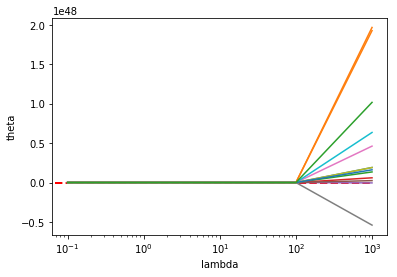

In [255]:
lamb = [0.1, 1, 10, 100, 1000]
theta = []

#####################################################################
# Instructions: For each value in lamb, try a model for it, and     #
#               append the trained weights into the theta           #
#####################################################################
for i, lamb_i in enumerate(lamb):
    log_reg_l2 = LogisticRegression(alpha=0.1, lamb=lamb_i, regularization='l2')
    log_reg_l2.fit(X_train, y_train, num_iter=500)
    theta.append(log_reg_l2.theta)

#####################################################################
#                       END OF YOUR CODE                            #
#####################################################################

plot_theta(np.array(theta), lamb)